## Einrichtung von Julia JuMP
---

Überprüfen Sie die bereits installierten Pakete. In der JuliaBox sind möglicherweise alle notwendigen Pakete bereits vorhanden.

In [26]:
using Pkg;
Pkg.status()

Status `C:\Users\krueg\.julia\environments\v1.4\Project.toml`
  [9961bab8] Cbc v0.7.0
  [e2554f3b] Clp v0.8.0
  [60bf3e95] GLPK v0.13.0
  [2e9cd046] Gurobi v0.8.0
  [7073ff75] IJulia v1.21.2
  [4076af6c] JuMP v0.21.2
  [f3b207a7] StatsPlots v0.14.6


Installieren Sie ``JuMP`` , mit dem Sie einfach Optimierungsprogramme formulieren können, sowie ``Cbc``, einen open-source Solver zum Lösen des Problems, und ``StatsPlots`` zur Visualisierung der Lösung.



In [27]:
#Pkg.add("JuMP")
#Pkg.add("Cbc");
#Pkg.add("StatsPlots");

   Updating registry at `C:\Users\krueg\.julia\registries\General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %

  Resolving package versions...
   Updating `C:\Users\krueg\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\krueg\.julia\environments\v1.4\Manifest.toml`
 [no changes]


Initialisieren Sie die installierten Pakete, damit sie im folgenden Notebook verwendet werden können.


In [28]:
using JuMP, Cbc, StatsPlots;

┌ Info: Precompiling Cbc [9961bab8-2fa3-5c5a-9d89-47fab24efd76]
└ @ Base loading.jl:1260


# Aggregierte Planung

### Entscheidungsvariablen:

Bestimmung der optimalen **Produktionsmengen, Absatzmengen, Fremdbezugsmengen** und **Lagerbestände** der Produkte, sowie der optimal zu nutzenden **Zusatzkapazität** der Ressourcen je Periode, 

### Zielfunktion:

0) **Deckungsbeitragsmaximierung**: $$  \qquad \max db = \displaystyle\sum_{i=1}^I \sum_{t=1}^T (e_iA_{it}-k_i^vX_{it}-k_i^l L_{it}-k_i^fF_{it}) - \sum_{j=1}^J \sum_{t=1}^T (k_j^zZ_{jt}) $$


### Nebenbedingungen:

1) **Kapazitaetsrestriktion:** $ \hspace{41mm} \sum_{i=1}^I(r_{ij}\cdot X_{it}) \leq c_j + z_{jt} \hspace{40mm} \forall j \in J, t \in T $

2) **Absatzobergrenze:** $\hspace{38mm} \qquad A_{it} \leq d_{it} \hspace{69mm} \forall i \in I , t \in T $


3) **Absatzuntergrenze:** $ \hspace{37mm}\qquad A_{it} \geq d_{it}^{min} \hspace{66mm} \forall i \in I , t \in T $
 
4) **Lagerbilanz:** $ \hspace{61mm} L_{it}=L_{i,t-1}+X_{it}-A_{it}+F_{it} \hspace{31mm} \forall i \in I , t \in T$

5) **Anfangslagerbestand:**   $ \hspace{43mm} L_{i,0} = l_{start} \hspace{64mm} \forall  i \in I$


6) **Max. Zusatzkapazität:** $ \hspace{44mm} Z_{jt} \leq z_j^{max}  \hspace{65mm} \forall j \in J, t \in T $

7) **Max. Fremdbezug:** $ \hspace{49mm} F_{it} \leq f_i^{max} \hspace{65mm} \forall i \in I, t \in T $

8) **Nichtnegativitätsbedingung:** $ \hspace{31mm} X_{it}, A_{it}, L_{it}, F_{it} \geq 0 \hspace{49mm} \forall i \in I, t \in T$

und $\hspace{81mm} Z_{jt} \geq 0 \hspace{71mm}  \forall j \in J, t \in T $ 

* * *

## Verwendete Symbole

### Mengen

$i \in (1,..,I)\hspace{20mm} $ Produkte  

$j \in (1,..,J)\hspace{20mm}$  Ressourcen 

$t \in (1,..,T)\hspace{20mm}$  Zeiten 

### Variablen

$X_{it}$  $\geq0$      $\hspace{28mm}$ Produktionsmenge      

$A_{it}$  $ \geq 0 $  $\hspace{28mm} $ Absatzmenge 

$L_{it}$  $\geq0$  $\hspace{28mm} $ Lagerbestand  

$F_{it}$       $ \geq0$    $\hspace{28mm} $ Fremdbezug   

$Z_{jt}$      $\geq0$      $\hspace{27mm} $ Zusatzkapazität  


### Parameter

$e_i \hspace{39mm}$   Erlös    

$k_i^v \hspace{38mm}$ variable Kosten

$k_i^l \hspace{38mm}$ Lagerkostensatz 

$k_j^z \hspace{38mm}$ Überstundenkostensatz 

$k_i^f \hspace{38mm}$ Fremdbezugskosten 

$d_{it} \hspace{38mm}$  Nachfrage  

$d_{it}^{min} \hspace{36mm}$ Absatzuntergrenze  

$r_{ij} \hspace{38mm}$  Produktionskoeffizient 

$c_j \hspace{39mm}$  Kapazität  

$l_{start} \hspace{34mm}$  Anfangslagerbestand  

$z_j^{max} \hspace{34mm}$ max. Zusatzkapazität 

$f_i^{max} \hspace{33mm}$  max. Fremdbezug

 * * *
 

## Erstellen Sie das Modell namens ``m`` und geben Sie als zu verwendenden Solver Cbc an.
---

In [29]:
m = Model(Cbc.Optimizer);

### Mengen und Parameter
---

Fügen Sie die Mengen ein.

In [30]:
#Mengen
Produkte =   ["Hell", "Dunkel"];
Ressourcen = ["Herstellen", "Abfuellen"];
Perioden =   ["Mo", "Di", "Mi", "Do", "Fr"];

#Längen
I = length(Produkte);
J = length(Ressourcen);
T = length(Perioden);

Fügen Sie die Parameter ein.

In [31]:
     #Herstellen, Abfüllen
r = [  12           4         #Hell
       15           4   ]     #Dunkel

#Ressourcenverbrauch von Ressource j durch Produkt i

      #Mo, Di, Mi, Do, Fr
d = [  70  65  75  80  110    #Hell
       55  35  40  65  80 ]   #Dunkel

#Nachfrage von Produkt i in Periode t
 
        #Mo, Di, Mi, Do, Fr
dmin = [ 30  30  30  30  30    #Hell
         20  20  20  20  40 ]; #Dunkel

#Absatzuntergrenze von Produkt i in Periode t

In [32]:
c =  [750, 250];   #Kapazität der Ressource j

e =  [3, 3.5];     #Erlös des Produktes

kf = [0, 0];       #Fremdbezugskostensatz der Produkte

kl = [0.5, 0.5];   #Lagerkostensatz der Produkte

kz = [0.25, 0.2];  #Überstundenkostensatz von Ressource j

kv = [1, 1.25];    #variable Herstellkosten der Produkte

zmax = [300, 300]; #Max. Zusatzkapazität von Ressource j

l_start =  [0, 0]; #Anfangslagerbestand der Produkte


         #Mo, Di, Mi, Do, Fr
fmax =  [  0   0   0   0   0   #Hell         
           0   0   0   0   0]; #Dunkel

                  #Maximaler Fremdbezug von Produkt i in Periode t

### Entscheidungsvariablen
---
Definieren Sie die Entscheidungsvariablen. Achten Sie auf die Definitionsbereiche (Nebenbedingung 6):

8) **Nichtnegativitätsbedingung**: Die Entscheidungsvariablen, also die Produktions- und Absatzmengen, Lagerbestände, Fremdbezugsmengen und die in Anspruch genommenen Zusatzkapazitäten dürfen nur positive Werte annehmen, wir setzen deren Nichtnegativität voraus.

$ \qquad X_{it}, A_{it}, L_{it}, F_{it} \geq 0 \qquad \qquad \forall i \in I, t \in T$

und $\qquad \qquad Z_{jt} \geq 0 \qquad \qquad \qquad  \forall j \in J, t \in T $ 

In [33]:
@variables  m begin
            X[1:I,1:T]>=0,Int  #Produktionsmenge von Produkt i in Periode t
            A[1:I,1:T]>=0,Int  #Absatzmenge von Produkt i in Periode t
            F[1:I,1:T]>=0,Int  #Fremdbezugsmenge von Produkt i in Periode t
            Z[1:J,1:T]>=0,Int  #Zusatzkapazität von Ressource j in Periode t
            L[1:I,0:T]>=0,Int; #Lagerbestand von Produkt i am Periodenende von t
            end

## Zielfunktion

0) **Deckungsbeitragsmaximierung:** Der Gesamtdeckungsbeitrag db soll maximiert werden. Dieser berechnet sich hier aus der Summe der einzelnen Produkterlöse abzüglich der variablen Kosten, abzüglich der Lagerkosten, abzüglich der Fremdbezugskosten und wird Zusätzlich noch verringert um die Zusatzkapazitätskosten der Ressourcen.

$  \qquad \max db = \displaystyle\sum_{i=1}^I \sum_{t=1}^T (e_iA_{it}-k_i^vX_{it}-k_i^l L_{it}-k_i^fF_{it}) - \sum_{j=1}^J \sum_{t=1}^T (k_j^zZ_{jt}) $

In [34]:
@objective(m, Max,  sum(e[i] * A[i,t] - kv[i] * X[i,t] - kl[i] * L[i,t] - kf[i] * F[i,t] 
           for i=1:I for t=1:T) - sum(kz[j] *Z[j,t] for j=1:J for t=1:T));

## Nebenbedingungen

1) **Kapazitätsrestriktion**: Die zur Verfügung stehende Kapazität für die auf den einzelnen Ressourcen mögliche Produktionszeit darf nicht überschritten werden. Die Summe der Gesamtproduktionszeit aller Produkte $ i = 1,...,I $ auf den einzelnen Ressourcen j darf in jeder Periode die jeweils verfügbare Kapazität  $𝑐_j$ ergänzt um die Zusatzkapazität $o_{jt}$  nicht überschreiten.

$ \qquad \sum_{i=1}^I(r_{ij}\cdot X_{it}) \leq c_j + z_{jt} \qquad \forall j \in J, t \in T $

In [35]:
@constraint(m, KapRes[t=1:T,j=1:J], sum(r[i,j] * X[i,t] for i=1:I) <= c[j] + Z[j,t]);

2) **Absatzobergrenze**: Für die Produkte existieren Absatzober- und untergrenzen basierend auf der Nachfrage. Die abgesetzte Menge der einzelnen Produkte kann diese Absatzobergrenze in keiner Periode überschreiten.

$ \qquad A_{it} \leq d_{it}^{max} \qquad \qquad \qquad \qquad \forall i \in I , t \in T $

In [36]:
@constraint(m, AbsOb[i=1:I,t=1:T], A[i,t] <= dmax[i,t]);

UndefVarError: UndefVarError: dmax not defined

3) **Absatzuntergrenze**: Für die Produkte existieren Absatzuntergrenzen basierend auf der Nachfrage. Die abgesetzte Menge der einzelnen Produkte kann diese Absatzuntergrenze in keiner Periode unterschreiten.

$ \qquad A_{it} \geq d_{it}^{min} \qquad \qquad \qquad \qquad \forall i \in I , t \in T $

In [37]:
@constraint(m, AbsUn[i=1:I,t=1:T], A[i,t] >= dmin[i,t]);

4) **Lagerbilanz**: Der Lagerbestand eines Produktes am Ende einer Periode berechnet sich aus der Summe der eingelagerten Menge in der Vorperiode, der Produktionsmenge und der Fremdbezugsmenge, abzüglich der abgesetzen Menge des Produktes.

$ \qquad L_{it}=L_{i,t-1}+X_{it}-A_{it}+F_{it} \qquad \forall i \in I , t \in T$

In [38]:
@constraint(m, Lager[i=1:I,t=1:T], L[i,t] == L[i,t-1] + X[i,t] + F[i,t] - A[i,t]);

5) **Anfangslagerbestand**: Der Anfangslagerbestand aller Produkte entspricht dem initial gesetzen $l_i$.
 
  $$ \qquad L_{i,0} = l_{start} \hspace{40mm} \forall  i \in I$$


In [39]:
@constraint(m, AnfLager[i=1:I], L[i,0] == l_start[i]);

6) **Max. Zusatzkapazität**: Die eingesetzten Zusatzkapazitäten (Überstunden) für jede Ressource müssen in jeder Periode unter der Obergrenze, der maximalen Zusatzkapazität, bleiben. Die maximale Zusatzkapazität ist für jede Ressource j einzeln gegeben.

$ \qquad Z_{jt} \leq z_j^{max}  \qquad \qquad \qquad \qquad \forall j \in J, t \in T $

In [40]:
@constraint(m, ZusatzKapa[j=1:J,t=1:T], Z[j,t] <= zmax[j] );

7) **Max. Fremdbezug**: Der dazugekaufte Fremdbezug jedes Produktes muss in allen Perioden unter der Obergrenze, dem maximalen Fremdbezug, bleiben. Der maximale Fremdbezug ist für jedes Produkt i einzeln gegeben. 

$ \qquad F_{it} \leq f_i^{max} \qquad \qquad \qquad \qquad \forall i \in I, t \in T $

In [41]:
@constraint(m, FremdB[i=1:I,t=1:T], F[i,t] <= fmax[i,t] );

## Lösen Sie das Modell.
---

In [42]:
optimize!(m)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 583.5 - 0.00 seconds
Cgl0003I 0 fixed, 8 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 18 rows, 38 columns (38 integer (0 of which binary)) and 66 elements
Cbc0012I Integer solution of -581.5 found by DiveCoefficient after 0 iterations and 0 nodes (0.03 seconds)
Cbc0012I Integer solution of -582.5 found by DiveCoefficient after 2 iterations and 0 nodes (0.03 seconds)
Cbc0031I 2 added rows had average density of 5.5
Cbc0013I At root node, 2 cuts changed objective from -583.5 to -582.5 in 3 passes
Cbc0014I Cut generator 0 (Probing) - 0 row cuts average 0.0 elements, 3 column cuts (3 active)  in 0.000 seconds - new frequency is 1
Cbc0014I Cut generator 1 (Gomory) - 2 row cuts average 5.5 elements, 0 column cuts (0 active)  in 0.000 seconds - new frequency is 1
Cbc0014I Cut generator 2

Lassen Sie sich das Modell anzeigen.

In [43]:
m

A JuMP Model
Maximization problem with:
Variables: 52
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.EqualTo{Float64}`: 12 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.GreaterThan{Float64}`: 10 constraints
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 30 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 52 constraints
`VariableRef`-in-`MathOptInterface.Integer`: 52 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: COIN Branch-and-Cut (Cbc)
Names registered in the model: A, AbsUn, AnfLager, F, FremdB, KapRes, L, Lager, X, Z, ZusatzKapa

Lassen Sie sich den Zielfunktionswert anzeigen.

In [44]:
println("Objective value db: ", JuMP.objective_value(m))

Objective value db: 582.5


Lassen Sie sich die Produktionsmengen, die Absatzmengen und die Lagermengen für Produkt "Hell" anzeigen.

In [45]:
bardataHell = [[JuMP.value(X[1,t]) for t in 1:T ] [JuMP.value(A[1,t]) for t in 1:T]
              [JuMP.value(L[1,t]) for t in 1:T ]];

ArgumentError: ArgumentError: block row 2 has mismatched number of columns (expected 2, got 1)

Stellen Sie diese grafisch dar.

In [46]:
groupedbar(bardataHell, label=["Produktionsmenge" "Absatzmenge" "Lagermenge"], title = "Produkt Hell",
           colour = [:DeepSkyBlue4 :Red3 :orange], xlabel = "Periode", ylabel = "Menge", ylim = (0,45))

UndefVarError: UndefVarError: bardataHell not defined

Lassen Sie sich die Produktionsmengen, die Absatzmengen und die Lagermengen für Produkt "Dunkel" anzeigen.

In [47]:
bardataDunkel = [[JuMP.value(X[2,t]) for t in 1:T ] [JuMP.value(A[2,t]) for t in 1:T] [JuMP.value(L[2,t])
                 for t in 1:T ]] 

5×3 Array{Float64,2}:
 20.0  20.0   0.0
 20.0  20.0   0.0
 26.0  20.0   6.0
 26.0  20.0  12.0
 28.0  40.0   0.0

Stellen Sie diese grafisch dar.

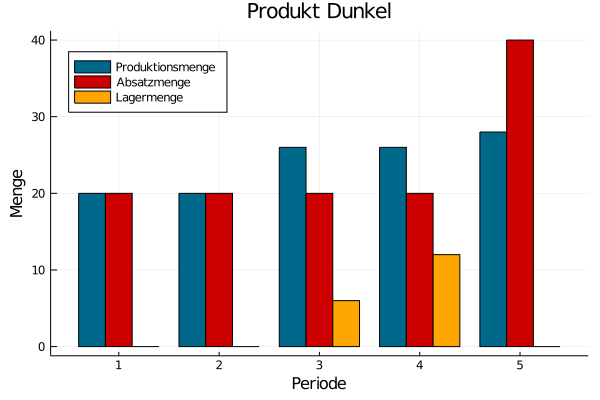

In [48]:
groupedbar(bardataDunkel,label=["Produktionsmenge" "Absatzmenge" "Lagermenge"], title = "Produkt Dunkel",
           colour = [:DeepSkyBlue4 :Red3 :orange], xlabel = "Periode", ylabel = "Menge",legend = :topleft)

Beide in einem:

In [49]:
l = @layout [a{0.9w, 0.1h} b]
p1 = groupedbar(bardataHell,colour = [:DeepSkyBlue4 :Red3 :orange], title = "Produkt Hell", 
                xlabel = "Periode", ylabel="Menge", legend=:none, ylim=(0,40));

p2 = groupedbar(bardataDunkel, label=["Produktionsmenge" "Absatzmenge" "Lagerbestand"], 
                colour = [:DeepSkyBlue4 :Red3 :orange], title = "Produkt Dunkel", 
                xlabel = "Periode", ylabel="Menge", legend=:topleft, ylim=(0,40));

plot(p1, p2, layout = 2)

UndefVarError: UndefVarError: bardataHell not defined